In [150]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
from tqdm import tqdm
tqdm.pandas()


In [2]:
train_df=pd.read_csv('./Data/train.csv')

In [3]:
train_df

,id,y,var1,var2,var3,t1_2001,t2_2001,t3_2001,t4_2001,t5_2001,...,t106_9170,t107_9170,t108_9170,t109_9170,t110_9170,t111_9170,t112_9170,t113_9170,t114_9170,t115_9170
0,1,113.0,19,A,A,-0.140642,-0.388162,-0.574181,-0.583770,-0.376220,...,0.584130,-0.100278,-0.846640,-1.461938,-1.801008,-1.804553,-1.500023,-0.980571,-0.377526,0.168243
1,2,119.0,14,C,A,0.023754,-0.105455,-0.245025,-0.310670,-0.249384,...,-3.024336,-2.480266,-1.118005,0.181451,0.726820,0.401501,-0.356744,-0.913405,-0.854943,-0.193468
2,3,109.0,13,A,A,0.180818,0.135004,0.001879,-0.134548,-0.185928,...,-0.156851,-0.262902,-0.668436,-1.172372,-1.387328,-1.016077,-0.103130,0.935900,1.550512,1.405350
3,4,110.0,18,A,A,-0.234780,-0.094543,0.193084,0.508519,0.668783,...,-1.358540,-0.028478,0.535346,-0.116384,-1.542395,-2.486781,-1.631185,1.481241,6.015514,10.233163
4,5,123.0,32,A,A,-0.130934,-0.360313,-0.547045,-0.603495,-0.508025,...,-0.825535,-0.392556,0.156361,0.567142,0.756362,0.809336,0.844580,0.876423,0.801686,0.524566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,794,110.0,41,A,A,0.059091,0.102927,0.167974,0.235793,0.242588,...,-0.057536,-0.750600,-1.422304,-1.807741,-1.349442,0.350016,2.341956,2.732083,0.976598,-1.039106
596,795,120.0,64,A,A,-0.009643,-0.052258,0.011368,0.121682,0.143449,...,-0.811138,-0.834139,-0.658424,-0.346113,-0.197853,-0.308410,-0.359883,-0.070181,0.296186,0.199696
597,797,96.0,27,A,A,-0.019310,0.082953,0.222301,0.374440,0.447602,...,1.337280,1.089598,1.323202,1.535013,1.084823,0.206892,-0.139006,0.299608,0.321211,-1.356280
598,798,118.0,29,C,A,0.554973,0.227389,-0.422503,-0.088061,0.210051,...,1.632523,2.674116,1.483660,1.520353,-0.672479,-3.975402,-2.972622,0.292423,1.244024,1.499407


In [7]:
def get_corr(row, test=False):
    if test:
        brain = np.array(row[4:])
    else:
        brain = np.array(row[5:])
    brain = brain.reshape((116, 115)).astype(float)
    corr = np.corrcoef(brain)
    flat = corr[np.triu_indices(corr.shape[0], 1)]
    return flat.tolist()

def get_corr_2(row, test=False):
    if test:
        brain = np.array(row[4:])
    else:
        brain = np.array(row[5:])
    brain = brain.reshape((116, 115)).astype(float)
    brain = normalize(brain, norm='l1')
    # Intercorrelation
    reg = LinearRegression(normalize=True).fit(brain[:-1], brain[1:])
    # coef = normalize(reg.coef_, norm='l1')
    coef = normalize(reg.coef_, norm='l1')
    return coef.flatten().tolist()
    
    # flat = []
    # for i in range(116):
    #     for j in range (i+1, 116):
    #         flat.append(np.correlate(brain[i], brain[j]))
    # return flat
    
    # Correlation of derivatives
    # brain = np.diff(brain)
    # corr = np.corrcoef(brain)
    # flat = corr[np.triu_indices(corr.shape[0], 1)]
    # return flat.tolist()
    
def get_corr_fft(row, test=False):
    if test:
        brain = np.array(row[4:])
    else:
        brain = np.array(row[5:])
    brain = brain.reshape((116, 115)).astype(float)
    # fft_modules = np.absolute(np.fft.fft(brain))
    fft_modules = np.fft.fft(brain)
    fft_corr = np.corrcoef(fft_modules)
    flat = fft_corr[np.triu_indices(fft_corr.shape[0], 1)]
    return np.real(flat).tolist()

In [143]:
corr = train_df.progress_apply(get_corr,axis=1)
corr_df=pd.DataFrame(np.array(corr.values.tolist())).fillna(0)
corr_df

  0%|▏                                                                                 | 1/600 [00:00<02:12,  4.52it/s]C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 257.19it/s]


,0,1,2,3,4,5,6,7,8,9,...,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669
0,0.320408,-0.156421,-0.115766,-0.306091,0.034975,-0.147885,-0.228411,-0.237148,0.020136,0.445899,...,0.006686,-0.285579,-0.072048,0.411215,0.322524,0.208173,-0.071341,0.282784,-0.055727,0.144371
1,0.386406,0.084164,-0.226632,-0.136301,-0.428097,-0.126119,-0.057845,-0.122750,-0.262477,0.594780,...,0.736991,0.147084,-0.159465,0.264405,0.006974,0.009238,0.266661,0.047870,0.112745,0.142081
2,0.809958,0.096828,-0.012295,-0.658145,-0.565232,0.436640,0.163701,-0.528475,-0.458596,0.313225,...,0.200037,0.393775,-0.085829,0.266476,0.340162,-0.142864,0.342046,0.374683,0.281569,-0.166943
3,0.371073,0.340416,0.165785,0.319523,0.071653,-0.006067,0.102873,0.247239,0.153692,0.145438,...,0.711573,0.449607,-0.101063,0.494471,0.630120,0.089310,0.583527,0.391849,0.529610,0.202928
4,0.238808,-0.075542,-0.312048,0.343195,-0.017375,0.279959,-0.206112,0.266237,-0.035437,0.385538,...,0.464747,0.110613,0.242850,0.180382,0.264813,0.369938,0.449401,-0.011589,0.637432,0.323892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.239704,0.334075,-0.133219,0.396904,0.218766,0.401353,-0.211222,0.330301,0.118898,0.499315,...,0.868837,0.570910,0.411275,0.662582,0.576929,0.390116,0.636213,0.414633,0.584703,0.823124
596,0.082087,0.106322,-0.234501,-0.227719,-0.221337,0.428577,-0.541010,0.058470,-0.258668,0.710444,...,0.192933,-0.112865,0.101323,0.343547,0.358325,0.412704,0.412598,0.035520,-0.126774,0.412996
597,0.550363,-0.173623,-0.087052,-0.076264,-0.334513,0.005763,-0.164106,-0.227619,-0.378778,0.688334,...,0.673816,0.309224,0.328117,0.451602,0.389896,0.261399,0.427783,0.504431,0.574561,0.499287
598,0.302419,0.042842,-0.557081,-0.029869,-0.165823,0.216248,-0.262268,0.092553,-0.006392,0.256167,...,0.168198,0.348409,-0.134313,0.081805,0.124225,-0.034212,-0.042134,0.136920,0.025787,-0.288578


In [144]:
pca_corr = PCA()
corr_df_transformed = pca_corr.fit_transform(corr_df)
print(pca_corr.explained_variance_ratio_.sum())
print(corr_df_transformed.shape, corr_df.shape)

1.0
(600, 600) (600, 6670)


In [145]:
corr_2 = train_df.progress_apply(get_corr_2, axis=1)
# new_df_2 = pd.DataFrame(np.array(corr_2.values.tolist()),columns=[col+'-2' for col in columns]).fillna(0)
new_df_2 = pd.DataFrame(np.array(corr_2.values.tolist())).fillna(0)
new_df_2

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 133.87it/s]


,0,1,2,3,4,5,6,7,8,9,...,13215,13216,13217,13218,13219,13220,13221,13222,13223,13224
0,-0.000159,0.000708,-0.000540,-0.002777,0.007942,-0.008352,0.001637,0.006223,-0.010407,0.008046,...,0.009209,-0.009480,0.007839,-0.002904,-0.007528,0.014304,-0.011687,0.005279,-0.001292,0.000134
1,0.000820,-0.004216,0.008272,-0.007245,0.005127,-0.013125,0.020011,-0.003917,-0.015947,0.006496,...,0.003094,0.020509,-0.022030,0.005822,0.002587,0.001300,-0.005086,0.003799,-0.001286,0.000176
2,-0.000642,0.002890,-0.003811,-0.003179,0.014592,-0.014333,0.001725,0.000710,0.010931,-0.012033,...,-0.025030,0.017885,-0.005973,-0.002418,0.010283,-0.015798,0.013956,-0.007343,0.002177,-0.000285
3,-0.000749,0.005140,-0.013640,0.015669,-0.001427,-0.012758,0.004187,0.010821,-0.005903,-0.000054,...,0.006681,0.002933,-0.004804,-0.004705,0.010653,-0.007833,0.002933,-0.000533,0.000025,0.000003
4,-0.000526,0.001002,0.003584,-0.015358,0.020399,-0.005619,-0.009563,-0.000578,0.015773,-0.003787,...,-0.008433,-0.000331,0.000610,0.000837,0.001843,-0.005557,0.005852,-0.003333,0.001041,-0.000141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.000077,0.000601,-0.001918,0.003450,-0.003807,0.002865,-0.002666,0.004278,-0.005231,0.003765,...,0.012589,-0.000027,0.000196,-0.010731,0.019300,-0.018632,0.011678,-0.004874,0.001267,-0.000161
596,0.000257,-0.000322,-0.002449,0.011274,-0.023204,0.026911,-0.013863,-0.007651,0.019362,-0.015535,...,-0.006190,0.011043,-0.008856,0.001810,0.003832,-0.004975,0.003208,-0.001264,0.000292,-0.000029
597,0.000130,-0.000517,0.000529,0.001582,-0.006650,0.011830,-0.012134,0.006638,-0.000737,-0.000428,...,0.000811,-0.011914,0.017407,-0.014859,0.007942,-0.002056,-0.000476,0.000674,-0.000270,0.000045
598,0.000812,-0.001265,0.002380,-0.000471,-0.001095,0.006298,-0.006797,0.009405,-0.004278,0.004868,...,-0.001438,0.014542,-0.025941,0.025135,-0.016261,0.004027,0.002856,-0.004668,0.002642,-0.000952


In [146]:
pca_2 = PCA()
new_df_transformed = pca_2.fit_transform(new_df_2)
print(pca_2.explained_variance_ratio_.sum())
print(new_df_transformed.shape, new_df_2.shape)

1.0000000000000002
(600, 600) (600, 13225)


In [147]:
# X = pd.concat([pd.DataFrame(new_df_2)], axis=1) 
# X = pd.concat([pd.DataFrame(corr_df_transformed)], axis=1) 
X = pd.concat([pd.DataFrame(corr_df_transformed), pd.DataFrame(new_df_transformed)], axis=1) 
# X = pd.concat([pd.DataFrame(corr_df), pd.DataFrame(new_df_2)], axis=1) 
# X = pd.concat([pd.DataFrame(corr_df)], axis=1) 
# X = pd.concat([pd.DataFrame(corr_df_transformed)], axis=1) 
# X = pd.concat([corr_df,], axis=1)
# scaler = Normalizer()
# X = scaler.fit_transform(X)
# X = normalize(X) 
X = pd.DataFrame(normalize(X))
X['var1']=train_df['var1']
X['var2']=train_df['var2'].replace({'A':0, 'C':1})
X['var3']=train_df['var3'].replace({'A':0, 'C':1})
X

,0,1,2,3,4,5,6,7,8,9,...,1193,1194,1195,1196,1197,1198,1199,var1,var2,var3
0,0.043483,-0.101202,-0.060420,-0.135506,-0.038458,0.092759,0.023955,0.001306,0.016267,0.151630,...,-0.001507,0.000439,0.001122,0.000657,-0.000864,0.000719,5.504907e-18,19,0,0
1,0.099210,-0.287293,0.208188,-0.267666,0.066483,-0.068191,-0.228809,0.056611,0.170066,0.154557,...,0.000950,0.002722,-0.001132,-0.001631,0.000361,0.000199,4.683716e-18,14,1,0
2,0.015455,-0.156038,0.051598,0.094843,-0.006460,0.039775,0.088249,0.062156,0.005080,0.047515,...,0.001088,0.001135,-0.000445,0.000187,-0.000430,-0.000702,4.844100e-18,13,0,0
3,0.301902,0.127188,0.173297,0.017840,-0.053891,0.086986,-0.100666,-0.067231,0.056596,0.015271,...,-0.000338,-0.001914,-0.000769,0.001129,0.000469,-0.001678,4.357689e-18,18,0,0
4,-0.014422,0.060242,0.129965,-0.134889,0.008349,-0.081254,0.073355,0.179175,0.002612,-0.117312,...,-0.000292,0.000373,-0.003372,-0.001516,0.000027,0.000298,5.216885e-18,32,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.051188,0.064030,0.028881,0.151864,0.265728,0.231522,-0.104742,-0.044455,0.111947,0.008005,...,-0.001047,0.000300,0.003444,0.001369,-0.001805,0.000829,5.092755e-18,41,0,0
596,0.052832,0.232462,-0.088554,0.099750,0.003142,0.120740,-0.035770,-0.067721,0.050079,-0.002805,...,0.000849,0.002946,-0.000753,0.000798,0.001875,-0.000850,4.700922e-18,64,0,0
597,0.120969,0.016814,0.145047,-0.133204,-0.135566,0.043466,0.092569,-0.154964,0.088983,0.063070,...,-0.000596,0.001619,-0.000810,-0.001146,-0.000995,-0.000795,5.302244e-18,27,0,0
598,-0.159642,-0.071141,-0.189122,-0.022821,-0.143296,0.062580,-0.153472,-0.049388,-0.009561,0.035150,...,0.001250,0.000439,0.000960,0.000673,0.000460,-0.000415,5.771335e-18,29,1,0


In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, train_df['y'], test_size=0.33, random_state=42)

In [152]:
X_train, y_train = X, train_df['y']

In [ ]:
X_train.shape, y_train.shape

In [69]:
sm = RandomOverSampler(random_state=42)
y_train_pos = np.digitize(y_train, y_train.sort_values().unique())
X_res, y_res = sm.fit_resample(X_train, y_train_pos)
X_train, y_train = X_res, y_train.sort_values().unique()[y_res-1]

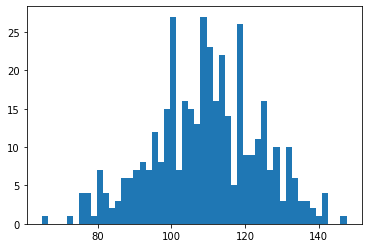

In [24]:
plt.hist(y_train, bins=50);

In [153]:
regr = ElasticNetCV(cv=3, random_state=0)
regr.fit(X_train,y_train)
y_pred=regr.predict(X_test)
mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)

(203.12066081134253, 14.252040584117859)

In [76]:
svr_reg=SVR(C=10, kernel='rbf', gamma='scale', coef0=10)
svr_reg.fit(X_train, y_train)
# svr_reg.fit(X, train_df['y'])
y_pred=svr_reg.predict(X_test)
mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)

(226.86335128502398, 15.061983643764323)

In [132]:
nn = MLPRegressor((250,100,100), verbose=True, max_iter=350)
nn.fit(X_train, y_train)
y_pred=nn.predict(X_test)
mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)

Iteration 1, loss = 6031.56639200
Iteration 2, loss = 5881.08405699
Iteration 3, loss = 5724.22740958
Iteration 4, loss = 5524.85584453
Iteration 5, loss = 5271.08455008
Iteration 6, loss = 4945.09209693
Iteration 7, loss = 4528.96365483
Iteration 8, loss = 4026.32100986
Iteration 9, loss = 3426.48998290
Iteration 10, loss = 2758.79943130
Iteration 11, loss = 2079.22823974
Iteration 12, loss = 1472.36096904
Iteration 13, loss = 1049.66259790
Iteration 14, loss = 956.36912268
Iteration 15, loss = 1082.42524874
Iteration 16, loss = 1237.27793208
Iteration 17, loss = 1207.09531356
Iteration 18, loss = 1015.20208517
Iteration 19, loss = 915.46463757
Iteration 20, loss = 916.81597534
Iteration 21, loss = 975.05484994
Iteration 22, loss = 992.94293825
Iteration 23, loss = 971.47157876
Iteration 24, loss = 931.97845038
Iteration 25, loss = 888.45985947
Iteration 26, loss = 861.59882390
Iteration 27, loss = 869.32783250
Iteration 28, loss = 878.26943741
Iteration 29, loss = 856.32843485
Iterat

Iteration 243, loss = 6.99734758
Iteration 244, loss = 7.17298434
Iteration 245, loss = 7.48360788
Iteration 246, loss = 7.60577918
Iteration 247, loss = 6.49114749
Iteration 248, loss = 7.92648457
Iteration 249, loss = 6.73384903
Iteration 250, loss = 6.33693557
Iteration 251, loss = 6.19878376
Iteration 252, loss = 5.73552103
Iteration 253, loss = 5.61485703
Iteration 254, loss = 5.57812760
Iteration 255, loss = 5.44914855
Iteration 256, loss = 5.33321616
Iteration 257, loss = 6.10532543
Iteration 258, loss = 6.89140383
Iteration 259, loss = 5.18201078
Iteration 260, loss = 5.95728445
Iteration 261, loss = 6.65325470
Iteration 262, loss = 4.77868041
Iteration 263, loss = 6.27491556
Iteration 264, loss = 7.45201336
Iteration 265, loss = 4.70924459
Iteration 266, loss = 6.34495724
Iteration 267, loss = 4.47033828
Iteration 268, loss = 4.57130655
Iteration 269, loss = 4.42147855
Iteration 270, loss = 3.86870041
Iteration 271, loss = 3.75756878
Iteration 272, loss = 3.69830546
Iteration 

C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


(368.53915024395974, 19.19737352462466)

In [ ]:
knn = KNeighborsRegressor(33, weights='distance')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)

In [94]:
mean_squared_error(y_test, [108]*len(y_test), squared=False)

15.107067380815009

In [95]:
np.quantile(y_test, q = [.25, 0.50, .75])

array([ 98.125, 108.5  , 118.75 ])

In [96]:
print(mean_squared_error(y_test, [98.125]*len(y_test), squared=False))
print(mean_squared_error(y_test, [108.5]*len(y_test), squared=False))
print(mean_squared_error(y_test, [118.75]*len(y_test), squared=False))

18.135080791191154
15.110075907797219
18.448998083989014


In [ ]:
y_pred=svr_reg.predict(X_test)

In [ ]:
y_pred=knn.predict(X_test)

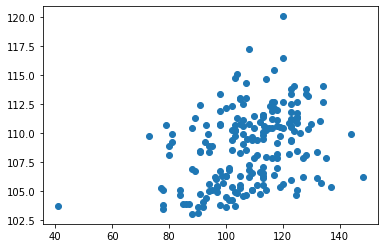

In [157]:
plt.scatter(y_test, y_pred)

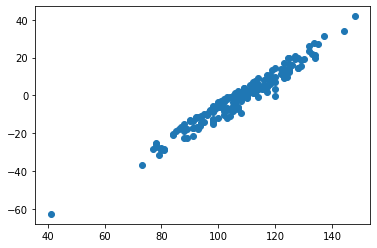

In [158]:
plt.scatter(y_test, (y_test-y_pred))

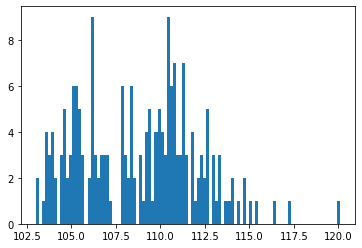

In [159]:
plt.hist(y_pred, bins=100);

In [115]:
test_df=pd.read_csv('./Data/test.csv')

In [ ]:
test_df

In [154]:
corr = test_df.progress_apply(lambda row: get_corr(row, test=True),axis=1)
corr_df = pd.DataFrame(np.array(corr.values.tolist())).fillna(0)
corr_df_transformed = pca_corr.transform(corr_df)
print(pca_corr.explained_variance_ratio_.sum())
print(corr_df_transformed.shape, corr_df.shape)
corr_df_transformed

  0%|                                                                                          | 0/199 [00:00<?, ?it/s]C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\miche\anaconda3\envs\datascience\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 254.98it/s]


1.0
(199, 600) (199, 6670)


array([[ 0.57065554, -1.7939898 , -0.24208013, ..., -0.10708824,
        -0.16941231, -0.10442264],
       [ 1.56993734, -1.45909109,  0.64561414, ..., -0.08164669,
        -0.06734222,  0.13121896],
       [-0.98417921,  0.52374489,  1.06126806, ...,  0.21734897,
         0.47295826,  0.17235345],
       ...,
       [-0.42634504,  6.32369871,  2.01386506, ..., -0.28280857,
        -0.34473274, -0.11393711],
       [ 0.28156627,  0.53991635, -0.42483328, ...,  0.07114553,
         0.04218676, -0.33694341],
       [ 1.87358166,  1.94565601, -1.41083865, ...,  0.20607013,
         0.0347724 , -0.20997934]])

In [155]:
corr_2 = test_df.progress_apply(lambda row: get_corr_2(row, test=True), axis=1)
new_df_2 = pd.DataFrame(np.array(corr_2.values.tolist())).fillna(0)
new_df_transformed = pca_2.transform(new_df_2)
print(pca_2.explained_variance_ratio_.sum())
print(new_df_transformed.shape, new_df_2.shape)
new_df_2

100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 149.83it/s]


1.0000000000000002
(199, 600) (199, 13225)


,0,1,2,3,4,5,6,7,8,9,...,13215,13216,13217,13218,13219,13220,13221,13222,13223,13224
0,0.000199,0.000354,-0.005333,0.015337,-0.020883,0.012421,0.005768,-0.020948,0.020588,-0.001344,...,0.009369,-0.002691,-0.002971,-0.007745,0.021767,-0.022046,0.011860,-0.003315,0.000303,0.000037
1,0.000653,-0.002793,0.004892,-0.004535,0.002627,0.001464,-0.011649,0.020314,-0.013229,-0.000329,...,-0.012102,0.001708,0.001784,0.005776,-0.015143,0.016923,-0.011432,0.004881,-0.001226,0.000139
2,0.001606,-0.008547,0.018838,-0.019231,0.003554,0.010097,-0.006354,0.001101,-0.009589,0.014622,...,-0.005767,0.002882,0.001789,0.004118,-0.008841,0.003028,0.004330,-0.005010,0.002124,-0.000348
3,-0.001157,0.006570,-0.015209,0.016154,-0.003273,-0.008522,0.005373,0.001975,-0.005067,0.012541,...,0.005633,-0.007670,0.013751,-0.008221,-0.004889,0.010958,-0.007808,0.002938,-0.000579,0.000046
4,0.001926,-0.009018,0.014383,-0.001443,-0.020887,0.014561,0.016548,-0.017588,-0.010129,0.006002,...,0.010519,-0.005005,-0.008205,0.011225,-0.003532,-0.002002,0.001790,-0.000368,-0.000042,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.000400,-0.002512,0.007221,-0.011045,0.006056,0.010383,-0.026101,0.024142,-0.005621,-0.007760,...,-0.013473,0.000477,0.006611,0.003537,-0.018769,0.023366,-0.016510,0.007321,-0.001945,0.000243
195,-0.000101,0.000865,-0.002976,0.005047,-0.003105,-0.004232,0.011107,-0.011209,0.007088,-0.004498,...,-0.000359,-0.012885,0.010180,-0.004227,0.003763,-0.005668,0.005217,-0.002811,0.000862,-0.000121
196,-0.001978,0.009588,-0.021057,0.024409,-0.011982,-0.002872,0.001293,0.009812,-0.009774,0.003641,...,-0.023015,0.019154,-0.013801,0.004950,0.004313,-0.008420,0.006739,-0.003184,0.000880,-0.000113
197,0.000200,-0.000763,0.001202,-0.000551,-0.001282,0.003367,-0.005551,0.008536,-0.011099,0.010156,...,-0.004039,0.009847,-0.011513,0.009550,-0.006115,0.003192,-0.001425,0.000551,-0.000164,0.000028


In [160]:
# X_test = pd.concat([pd.DataFrame(new_df_2)], axis=1) 
X_test = pd.concat([pd.DataFrame(corr_df_transformed), pd.DataFrame(new_df_transformed)], axis=1)
X_test = pd.DataFrame(normalize(X_test))
X_test['var1']=test_df['var1']
X_test['var2']=test_df['var2'].replace({'A':0, 'C':1})
X_test['var3']=test_df['var3'].replace({'A':0, 'C':1})
X_test

,0,1,2,3,4,5,6,7,8,9,...,1193,1194,1195,1196,1197,1198,1199,var1,var2,var3
0,0.049375,-0.155222,-0.020946,-0.061769,0.060888,-0.044532,-0.051191,-0.010289,-0.084646,-0.045284,...,0.001613,-0.001030,0.000237,-0.001295,0.002415,-0.000325,0.001285,32,0,0
1,0.132985,-0.123596,0.054688,-0.196427,0.001561,-0.191570,0.220897,-0.034414,-0.016217,-0.067110,...,-0.000302,-0.001498,-0.000022,-0.000694,-0.001993,-0.000637,0.000807,11,1,0
2,-0.072202,0.038423,0.077857,-0.254556,0.075304,0.193843,0.095754,0.192927,0.060735,-0.048818,...,0.001766,0.002668,-0.000416,-0.000249,0.000961,-0.000547,-0.000259,17,0,1
3,-0.205195,0.092808,0.003736,-0.309612,-0.064832,0.140251,0.215114,0.001662,0.041427,-0.175082,...,-0.001754,-0.000660,-0.001941,-0.001835,0.002352,0.000239,0.000705,17,0,1
4,-0.141476,-0.036149,-0.026988,-0.056883,-0.092265,0.113545,0.095311,0.060169,-0.206071,0.019100,...,0.002212,-0.000169,0.000884,0.000891,-0.003876,0.000780,-0.000907,16,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,-0.204597,-0.009008,0.000866,-0.067803,0.256701,0.280813,-0.216935,-0.043221,0.286865,0.024710,...,0.001316,-0.002814,-0.000977,0.002809,-0.000022,-0.000476,0.000393,20,0,1
195,0.076871,-0.200372,0.080101,0.044062,0.305105,0.200183,-0.065794,-0.032105,-0.116973,-0.079529,...,0.001522,0.001261,-0.000274,0.000813,0.002191,-0.002737,0.000685,24,0,1
196,-0.026175,0.388230,0.123637,-0.135133,0.058728,0.199630,0.142411,-0.010310,-0.003631,0.229988,...,-0.000346,0.000515,0.000077,0.000926,0.000993,-0.001487,-0.000483,24,0,1
197,0.025879,0.049625,-0.039047,-0.087155,0.302098,0.229284,-0.077594,-0.098570,0.014399,0.030310,...,-0.000635,0.002588,0.000691,-0.002228,-0.000180,0.001079,-0.000127,29,1,1


In [162]:
# y_pred=nn.predict(X_test)
y_pred=regr.predict(X_test)

In [ ]:
print(mean_squared_error(y_test, [98.125]*len(y_test), squared=False))
print(mean_squared_error(y_test, [108.5]*len(y_test), squared=False))
print(mean_squared_error(y_test, [118.75]*len(y_test), squared=False))

In [164]:
df_leaderboard=pd.DataFrame({'id':test_df['id'], 'target':y_pred})
df_leaderboard.to_csv('G14_10', index=False)
df_leaderboard

,id,target
0,17,108.866155
1,19,104.041381
2,25,111.741285
3,32,112.177245
4,33,110.654347
...,...,...
194,777,113.565929
195,783,111.553041
196,784,113.364817
197,792,113.599683
